In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_root = Path("./results")
hflop_root = data_root / "hflop"
hier_root = data_root / "hier"
flat_root = data_root / "non_hier"

assert hflop_root.is_dir() and hier_root.is_dir() and flat_root.is_dir()

In [4]:
df_hflop = pd.read_csv(hflop_root / "calculations.txt", header=None)
latencies_hflop = pd.read_csv(hflop_root / "latencies.txt", header=None)

df_hflop["e2e"] = df_hflop[0] + latencies_hflop[0]

df_hflop.head(n=10)



,0,e2e
0,0.044811,0.049712
1,0.000754,0.007735
2,0.003046,0.012605
3,0.000513,0.009645
4,0.046306,0.049180
5,0.003823,0.011755
6,0.001243,0.006938
7,0.004485,0.007714
8,0.003975,0.009076
9,0.002433,0.007883


In [5]:
speedups = np.linspace(0, 95, 21)


calcs_hier = pd.read_csv(hier_root / "calculations.txt", header=None)
latencies_hier = pd.read_csv(hier_root / "latencies.txt", header=None)

# gp1 clients have speed ups
latencies_gp1 = latencies_hier[latencies_hier[0] > 0.05]
calcs_gp1 = calcs_hier.loc[latencies_gp1.index]
latencies_gp2 = latencies_hier[latencies_hier[0] <= 0.05]
calcs_gp2 = calcs_hier.loc[latencies_gp2.index]

# apply speedup for the two client
df_hier_gp1 = pd.DataFrame([(s, val[0] * (1 - (s / 100.))) for s in speedups for val in calcs_gp1.to_numpy()], columns=['speedup', 'value'])

# "static" 0 speedup for other clients
df_hier_gp2 = pd.DataFrame([(s, val[0]) for s in speedups for val in calcs_gp2.to_numpy()], columns=['speedup', 'value'])

print(len(latencies_gp1))
print(len(latencies_gp2))

latencies_gp1_rep = np.tile(latencies_gp1.values.reshape(-1), len(speedups))
latencies_gp2_rep = np.tile(latencies_gp2.values.reshape(-1), len(speedups))


df_hier_gp1["e2e"] = df_hier_gp1["value"] + latencies_gp1_rep
df_hier_gp2["e2e"] = df_hier_gp2["value"] + latencies_gp2_rep
# 

df_hier = pd.concat([df_hier_gp1, df_hier_gp2])


200
1800


In [240]:
len(calcs_gp1)

200

In [204]:
assert all(df_hier_gp2["value"].to_numpy()[1800:3600] == df_hier_gp2["value"].to_numpy()[0:1800])

In [206]:
df_hier_gp1[2000:]

,speedup,value,e2e
2000,47.5,0.002036,0.072638
2001,47.5,0.002352,0.072955
2002,47.5,0.040853,0.136500
2003,47.5,0.001373,0.097021
2004,47.5,0.001874,0.097521
...,...,...,...
37795,0.0,0.002904,0.012450
37796,0.0,0.000854,0.009595
37797,0.0,0.002303,0.007362
37798,0.0,0.001627,0.008159


In [243]:
print(df_hier[df_hier["speedup"] == 0.0]["e2e"].mean())
print(df_hier[df_hier["speedup"] > 0.0]["e2e"].mean())

0.017716505483136635
0.01745097270135687


In [219]:
print(calcs_gp2[0].mean())
print(calcs_gp1[0].mean())

0.003451026678085281
0.005323965549468946


In [153]:
calcs_flat = pd.read_csv(flat_root / "calculations.txt", header=None)
latencies = pd.read_csv(flat_root / "latencies.txt", header=None)

# reduce not incrase time 
df_flat = pd.DataFrame([(s, val[0] * (1 - (s / 100.))) for s in speedups for val in calcs_flat.to_numpy()], columns=['speedup', 'value'])

assert len(df_flat) == len(speedups) * len(calcs_flat)
assert len(df_flat) == len(df_hier)

latencies_rep = np.tile(latencies.values.reshape(-1), len(speedups))
assert all(latencies_rep[2000:4000] == latencies_rep[0:2000])
df_flat["e2e"] = df_flat["value"] + latencies_rep 

In [150]:
df_flat[4000:]

,speedup,value,e2e,Method
4000,100.0,0.000000,0.093885,Non-Hierarchical
4001,100.0,0.000000,0.070555,Non-Hierarchical
4002,100.0,0.000000,0.066812,Non-Hierarchical
4003,100.0,0.000000,0.075173,Non-Hierarchical
4004,100.0,0.000000,0.091894,Non-Hierarchical
...,...,...,...,...
41995,1000.0,-0.036862,0.041134,Non-Hierarchical
41996,1000.0,-0.005414,0.058980,Non-Hierarchical
41997,1000.0,-0.025442,0.068443,Non-Hierarchical
41998,1000.0,-0.030963,0.067776,Non-Hierarchical


In [146]:
calcs_flat

,0
0,0.050594
1,0.001880
2,0.003478
3,0.002418
4,0.002943
...,...
1995,0.004096
1996,0.000602
1997,0.002827
1998,0.003440


/tmp/ipykernel_83830/1672305611.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  plot.legend(handles=leg.legendHandles + [red_line])


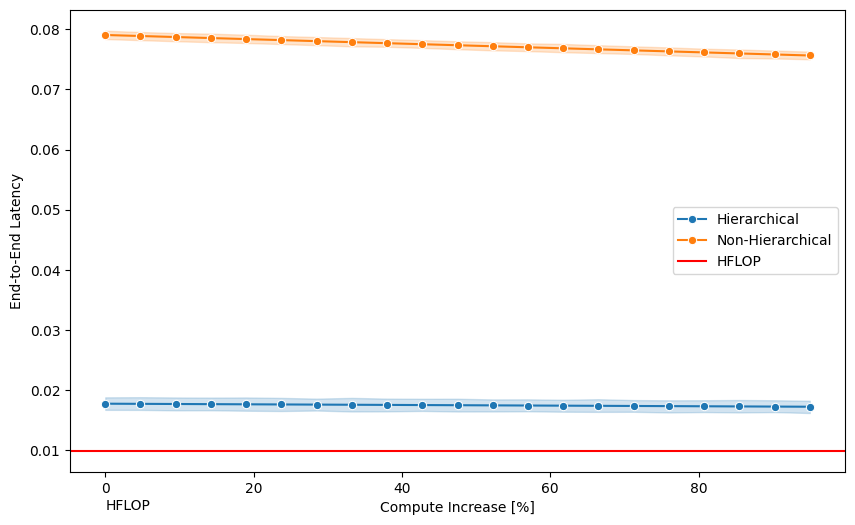

In [253]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

df_hier_gp1["Method"] = "Hierachica-1l"
df_hier_gp2["Method"] = "Hierachical-2"
df_hier["Method"] = "Hierarchical"
df_flat["Method"] = "Non-Hierarchical"

df_res =  pd.concat([df_hier, df_flat])
plt.figure(figsize=(10,6)) 
plot = sns.lineplot(x='speedup', y='e2e', hue='Method', data=df_res, errorbar='ci', marker='o')

hflops_constant = df_hflop["e2e"].mean()
plt.axhline(y=hflops_constant, color="r")

# Make a legend for the meaning of the line color.
red_line = mlines.Line2D([], [], color='red', label='HFLOP')

# Get the current legend
leg = plot.legend_

# Manually update the legend
leg.get_lines().append(red_line)
leg.get_texts().append(plt.text(0, 0, 'HFLOP'))

# Update the legend with the custom legend
plot.legend(handles=leg.legendHandles + [red_line])
plt.title('')
plt.xlabel('Compute Increase [%]')
plt.ylabel('End-to-End Latency')

plt.show()